# Overview of the classical tools for Natural Language Processing in sentiment analysis

Author: Séhane BEL HOUARI-DURAND

In this project, we will load the IDMb dataset, consisting of text reviews of films, labeled by an appreciation : 1 if the review is positive, 0 if it is negative. 
The goal will, given the text, be to predict the label, which is producing a model that, given a text input, will decide whether the text is (semantically) positive or negative.

To do so, we will analyse the dataset before testing 2 kinds of word embeddings, and 2 models for each : 
- A TD-IDF embedding, that simply maps a text to a vector representing some frequency or absence of each word. We will use on it a naive MoE model and a logistic regression
- A word2vec embedding that maps each word to a vector capturing its "meaning", so each text to a matrix. We will use a CNN and a LSTM over this embedding.  










Let's first load a bunch of libraries and the IDMb dataset.

In [159]:
from datasets import load_dataset, concatenate_datasets

# We import the NLTK library for basic NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#umap is useful to plot high dimentionnal data
import umap
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import gensim
from gensim.models import Word2Vec


from torch.optim.lr_scheduler import ExponentialLR



In [160]:
dataset = load_dataset("imdb")

## 1) Exploratory Data Analysis
We are using the imdb dataset. This dataset is already clean, but let's have a deeper look at it.

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\1191689543.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_train, palette="viridis", ax=axes[0])
C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\1191689543.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_test, palette="plasma", ax=axes[1])


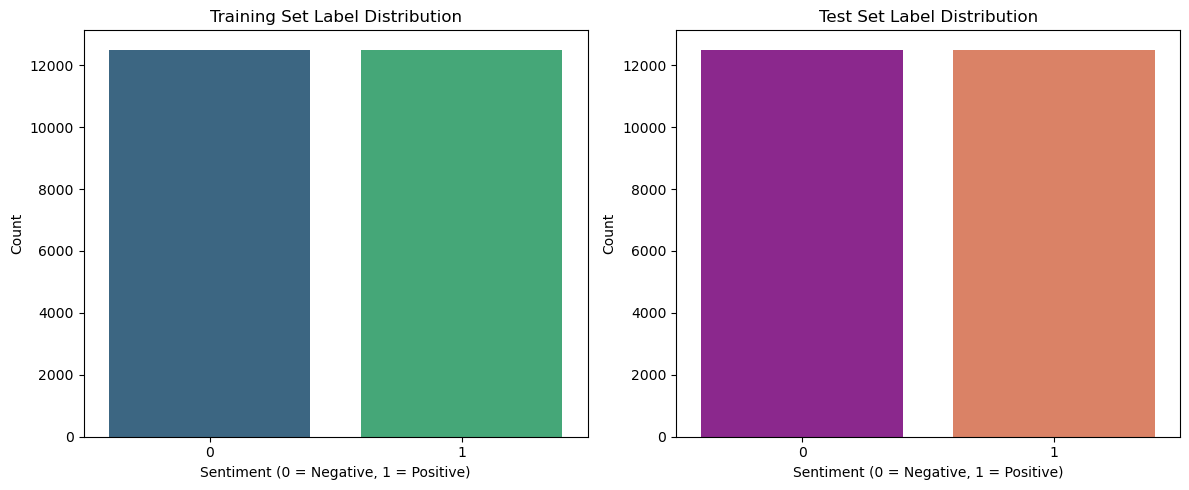


Class distribution in the Training set:
Class 0: 50.00%
Class 1: 50.00%

Class distribution in the Test set:
Class 0: 50.00%
Class 1: 50.00%
Size of the Training set 25000
Size of the test set 25000


In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset into Pandas DataFrame
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count class distribution for training set
sns.countplot(x="label", data=df_train, palette="viridis", ax=axes[0])
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xlabel("Sentiment (0 = Negative, 1 = Positive)")
axes[0].set_ylabel("Count")

# Count class distribution for test set
sns.countplot(x="label", data=df_test, palette="plasma", ax=axes[1])
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xlabel("Sentiment (0 = Negative, 1 = Positive)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print class distribution percentages
for dataset_name, df in zip(["Training", "Test"], [df_train, df_test]):
    class_counts = df["label"].value_counts(normalize=True)
    print(f"\nClass distribution in the {dataset_name} set:")
    for label, percentage in class_counts.items():
        print(f"Class {label}: {percentage:.2%}")
print(f"Size of the Training set {len(df_train)}")
print(f"Size of the test set {len(df_test)}")

This dataset is thus already balanced.

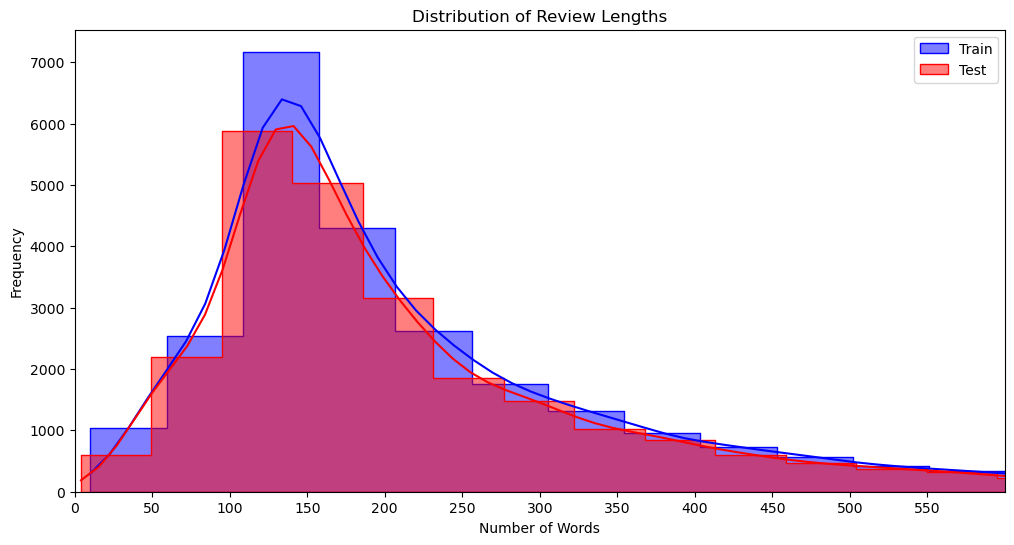

In [164]:
# Compute text lengths
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))

# Use step histograms to differentiate distributions
sns.histplot(df_train["text_length"], bins=50, kde=True, color="blue", label="Train", alpha=0.5, element="step")
sns.histplot(df_test["text_length"], bins=50, kde=True, color="red", label="Test", alpha=0.5, element="step")

# Zoom into the important range
plt.xlim(0, 600)  # Focus on the region of interest
plt.xticks(range(0, 600, 50))  # More detailed ticks

plt.legend()
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sidis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\1405059956.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=common_words, palette="magma")


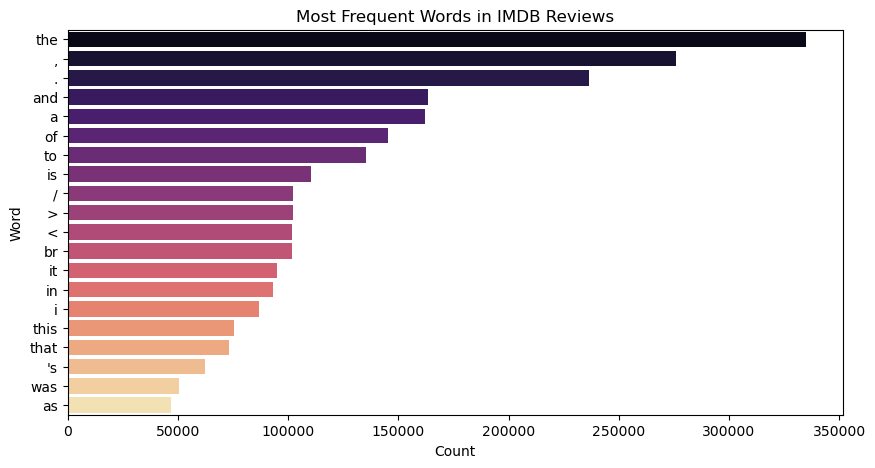

In [165]:
nltk.download('punkt')

# Tokenize and count words
all_words = [word.lower() for text in df_train["text"] for word in word_tokenize(text)]
word_freq = Counter(all_words)

# Plot top 20 words (excluding stopwords)
common_words = pd.DataFrame(word_freq.most_common(20), columns=["word", "count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="count", y="word", data=common_words, palette="magma")
plt.title("Most Frequent Words in IMDB Reviews")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


In [166]:
print(f"Missing values in train:\n{df_train.isnull().sum()}")
print(f"Missing values in test:\n{df_test.isnull().sum()}")

print(f"Duplicate entries in train: {df_train.duplicated().sum()}")
print(f"Duplicate entries in test: {df_test.duplicated().sum()}")

Missing values in train:
text           0
label          0
text_length    0
dtype: int64
Missing values in test:
text           0
label          0
text_length    0
dtype: int64
Duplicate entries in train: 96
Duplicate entries in test: 199


Let's restrict to a part of the dataset and split it into the training, validation and the test sets.


In [168]:
# Get the training and test datasets
train_data = dataset['train']
test_data = dataset['test']

# Randomly sample 10,000 positive and 10,000 negative reviews 
nb_of_samples=10000
positive_samples = train_data.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(nb_of_samples))
negative_samples = train_data.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(nb_of_samples))

# Merge and shuffle the two datasets 
train_val_sample = concatenate_datasets([positive_samples, negative_samples]).shuffle(seed=42)

# Create validation split (80% train, 20% validation)
train_size = int(0.8 * len(train_val_sample))  # 80% for training
val_size = len(train_val_sample) - train_size  # 20% for validation

train_sample = train_val_sample.select(range(train_size))
val_sample = train_val_sample.select(range(train_size, len(train_val_sample)))


#We make a test set of half the size of the training set
nb_of_test_samples=int(nb_of_samples/2)
positive_test_samples = test_data.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(nb_of_test_samples))
negative_test_samples = test_data.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(nb_of_test_samples))

test_sample = concatenate_datasets([positive_test_samples, negative_test_samples]).shuffle(seed=42)

print(f"There are {len(train_sample)} training samples, {len(val_sample)} validation samples and {len(test_sample)} test samples.")

There are 16000 training samples, 4000 validation samples and 10000 test samples.


The dataset is now done. Here are a few functions that are very useful to nicely compute and plot the performances of the model.

In [170]:

# Function to plot confusion matrix in a proper manner
def compute_y_pred_true_for_classification(model, test_loader):
    model.eval()
    #Let's first generate the y_pred and y_true vectors
    with torch.no_grad():
        y_pred = []
        y_true = []
    
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
        
            predictions = (output[:, 0] <= output[:, 1]).long()
        
            y_pred.append(predictions.cpu())  # Store predictions
            y_true.append(batch_y.cpu())  # Store true labels
    # Concatenate lists into single tensors
    y_pred = torch.cat(y_pred).numpy()
    y_true = torch.cat(y_true).numpy()

    return (y_true, y_pred)
    
def plot_confusion_matrix( y_true, y_pred):
    """
    Compute and plots a confusion matrix for binary classification.
    
    Args:
        y_true ( np.array): True labels (0 or 1).
        y_pred ( np.array): Predicted labels (0 or 1).
    
    """
    
    # getting min and max values
    min_label = min([np.min(y_true), np.min(y_pred)])
    max_label = max([np.max(y_true), np.max(y_pred)])# list of our test labels
    labels_test = [x for x in range(int(min_label), int(max_label)+1)]

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()

    classes = np.unique(labels_test)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            color = "white" if conf_matrix[i, j] > thresh else "black"
            if i == j:  # Highlight diagonal cells
                plt.text(j, i, format(conf_matrix[i, j], 'd'),
                        ha="center", va="center", color="red", fontsize=12)
            else:
                plt.text(j, i, format(conf_matrix[i, j], 'd'),
                        ha="center", va="center", color=color)
    plt.ylabel('True Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)

   

def plot_metrics_for_binary_classification( y_true, y_pred):
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred)
    }
    
    # Convert to DataFrame for easier handling
    df_metrics = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
    
    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")

    # Add numerical values on top of bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")

    # Formatting
    plt.ylim(0, 1)  # Metrics are between 0 and 1
    plt.title("Model Performance Metrics", fontsize=14)
    plt.ylabel("Score")
    plt.xlabel("")
    plt.show()


def compute_average_loss(model, criterion, data_loader, device):
    """
    This function computes the average loss of a model.
    And will usually be used on the validation set.
    
    """
    loss = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss += criterion(output, batch_y).item()
    
    return loss/len(data_loader)


## 2) TF-IDF embedding
Let's implement models that learns using the TF-IDF representation of the text. We will experiment two different models : MoE and LinearRegression. 

The first step is to preprocess the data and apply TF-IDF.

In [172]:


# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

#Initializations
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text_for_TDIDF(text, use_stemming=True):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    
    # Apply stemming or lemmatization
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Apply the preprocessing function to the reviews
train_sample = train_sample.map(lambda x: {'text': preprocess_text_for_TDIDF(x['text'])})

val_sample = val_sample.map(lambda x: {'text': preprocess_text_for_TDIDF(x['text'])})

test_sample = test_sample.map(lambda x: {'text': preprocess_text_for_TDIDF(x['text'])})


# Check the preprocessed data
print(train_sample[0])


{'text': 'two kind movi like western movi year ago ought like man call sledg br br pictur disagre annoy stupid start finish sinc nobodi stori good bad warm nobodi motiv necessari suspens keep viewer interest camaraderi among guy tri steal gold camaraderi among tri protect sledg pretti girl friend reason slobber guy want room br br film also suffer intrus gawdaw music score extrem bad write direct vic br br last older movi rent netflix video vault rock bottom true dud bunch', 'label': 0}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sidis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sidis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sidis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sidis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [173]:

# Sample corpus (list of preprocessed texts)
corpus = train_sample[:]['text']
labels = train_sample[:]['label']

# Sample test corpus (list of preprocessed texts)
test_corpus = test_sample[:]['text']
test_labels = test_sample[:]['label']

# Sample validation corpus (list of preprocessed texts)
val_corpus = val_sample[:]['text']
val_labels = val_sample[:]['label']

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF vectors and apply the transform to the test dataset
train_tfidf_matrix = vectorizer.fit_transform(corpus)
val_tfidf_matrix = vectorizer.transform(val_corpus)
test_tfidf_matrix = vectorizer.transform(test_corpus)

#let's have a look at the vocabulary
print(vectorizer.get_feature_names_out())

vocabulary_length=len(vectorizer.get_feature_names_out())

print("Vocabulary length : ", vocabulary_length)

['aa' 'aaa' 'aaaaah' ... 'østbye' 'über' 'üvegtigri']
Vocabulary length :  40153


Let's visualize the distribution of some of the training dataset's reviews with regard to the TD-IDF representation, using varions reduction of dimension techniques, namely UMAP, PCA and T-SNE.

It is good to notice that we did shuffle the dataset already, so picking the n first elements of it ammounts to picking n random samples.

C:\Users\sidis\anaconda3\envs\pytorch_jupyter\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sidis\anaconda3\envs\pytorch_jupyter\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


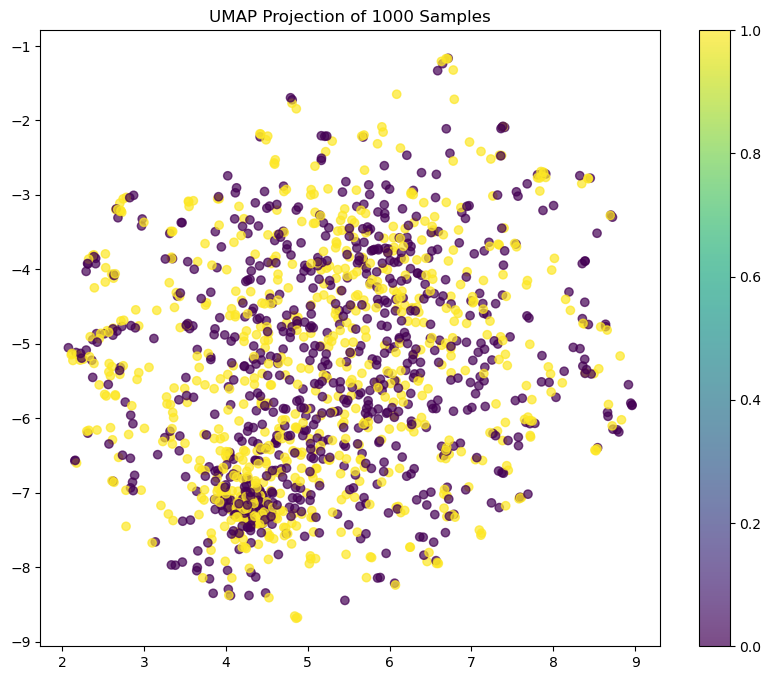

In [175]:
#We will extract num_samples_train_umap samples from the training dataset to train the UMAP model,
#and then plot num_samples_plot elements only, for a better visualisation

num_samples_plot=1500
num_samples_train_umap=4000

X_subset = train_tfidf_matrix[:num_samples_train_umap]  # Keep only the first 1000 rows
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_subset.toarray())

# Convert labels to NumPy array for proper indexing, and truncate for plotting
X_umap_plot=X_umap[:num_samples_plot]
labels_array = np.array(test_labels)[:num_samples_plot]

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_umap_plot[:, 0], X_umap_plot[:, 1], c=labels_array, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("UMAP Projection of 1000 Samples")
plt.show()


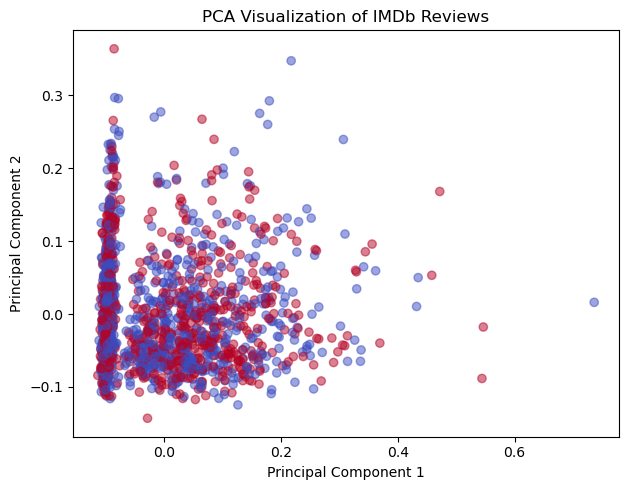

In [176]:
# The PCA is fast to compute, so we can train it on the whole dataset

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_tfidf_matrix)

#Truncate for ploting
X_pca_plot=X_pca[:num_samples_plot]
labels_array = np.array(test_labels)[:num_samples_plot]


# Plot PCA results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca_plot[:, 0], X_pca_plot[:, 1], c=labels_array, cmap='coolwarm', alpha=0.5)
plt.title("PCA Visualization of IMDb Reviews")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()




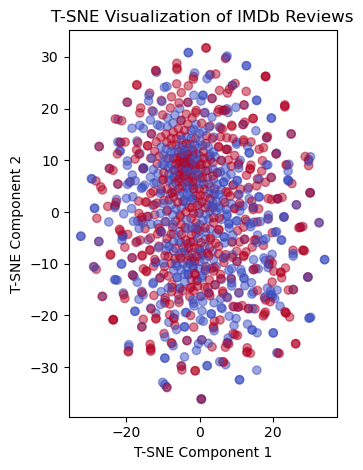

In [177]:
# The T-SNE model offers the best plot wen we plot the whole training set, 
#so we train it on num_samples_plot elements
num_samples_plot=1000

X_dense = train_tfidf_matrix[:num_samples_plot].toarray()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_dense)
X_tsne_plot = X_tsne[:num_samples_plot]

# Plot T-SNE results
plt.subplot(1, 2, 2)
plt.scatter(X_tsne_plot[:, 0], X_tsne_plot[:, 1], c=test_labels[:num_samples_plot], cmap='coolwarm', alpha=0.5)
plt.title("T-SNE Visualization of IMDb Reviews")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")

plt.tight_layout()
plt.show()

We see from these visualisations (especially T-SNE) that there is a separation in the dataset that we will be able to learn.

Now, we are going to train a MoE model on the dataset. The task is too simple for the model but it is still interesting to use it.
Here, we start by defining the model.

In [180]:


# Define the Gating Network, which selects which expert to use
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Outputs logits for each expert, softmax to get probabilities
        return F.softmax(self.fc(x), dim=-1)

#We use one expert that is a deep and narrow neural network
class DeepExpert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepExpert, self).__init__()
        self.inputlayer=nn.Linear(input_dim,16)
        self.hiddenlayers=nn.ModuleList()
        for _ in range(5):
            self.hiddenlayers.append(nn.Linear(16,16))
        self.outputlayer=nn.Linear(16,output_dim)
    def forward(self,x):
        x=self.inputlayer(x)
        for layer in self.hiddenlayers:
            x=layer(x)
        x=self.outputlayer(x)
        return x

#And we use an expert that is a linear model
class LinearExpert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearExpert, self).__init__()
        self.layer=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        x=self.layer(x)
        return x


class MoEModel2experts(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MoEModel2experts, self).__init__()

        #the first expert is a linear regression
        #the second expert is a deep and narrow fully connected neural network
        self.experts=nn.ModuleList([LinearExpert(input_dim,output_dim),DeepExpert(input_dim,output_dim)])
        
        self.gating_network = GatingNetwork(input_dim, 2)

    def forward(self, x):
        # Get the gating network output
        gating_weights = self.gating_network(x)  # Shape: [batch_size, num_experts]

        # Compute output from each expert
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # Shape: [batch_size, num_experts, output_dim]

        # The final output is the weighted sum of expert outputs, weighted by gating weights
        output = torch.sum(expert_outputs * gating_weights.unsqueeze(-1), dim=1)  # Shape: [batch_size, output_dim]
        
        return output


Using device: cuda
Epoch 1/20, Loss: 0.6918, Validation Loss: 0.6892, lr = 0.000100
Epoch 2/20, Loss: 0.6859, Validation Loss: 0.6819, lr = 0.000085
Epoch 3/20, Loss: 0.6693, Validation Loss: 0.6511, lr = 0.000072
Epoch 4/20, Loss: 0.5964, Validation Loss: 0.5361, lr = 0.000061
Epoch 5/20, Loss: 0.4395, Validation Loss: 0.3951, lr = 0.000052
Epoch 6/20, Loss: 0.3181, Validation Loss: 0.3295, lr = 0.000044
Epoch 7/20, Loss: 0.2603, Validation Loss: 0.3029, lr = 0.000038
Epoch 8/20, Loss: 0.2298, Validation Loss: 0.2910, lr = 0.000032
Epoch 9/20, Loss: 0.2107, Validation Loss: 0.2837, lr = 0.000027
Epoch 10/20, Loss: 0.1974, Validation Loss: 0.2800, lr = 0.000023
Epoch 11/20, Loss: 0.1875, Validation Loss: 0.2775, lr = 0.000020
Epoch 12/20, Loss: 0.1798, Validation Loss: 0.2762, lr = 0.000017
Epoch 13/20, Loss: 0.1739, Validation Loss: 0.2753, lr = 0.000014
Epoch 14/20, Loss: 0.1691, Validation Loss: 0.2746, lr = 0.000012
Epoch 15/20, Loss: 0.1652, Validation Loss: 0.2743, lr = 0.000010


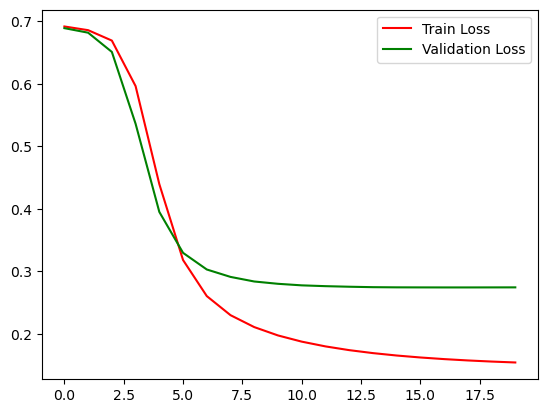

In [181]:

# Hyperparameters
input_dim = vocabulary_length  # Number of features in the input
output_dim = 2  # Number of output classes (e.g., binary classification)
batch_size = 128
num_epochs = 20
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to tensors
X = torch.tensor(train_tfidf_matrix.toarray(), dtype=torch.float).to(device)
y = torch.tensor(labels, dtype=torch.long).to(device)
x_test = torch.tensor(test_tfidf_matrix.toarray(), dtype=torch.float).to(device)
y_test = torch.tensor(test_labels, dtype=torch.long).to(device)
x_val = torch.tensor(val_tfidf_matrix.toarray(), dtype=torch.float).to(device)
y_val = torch.tensor(val_labels, dtype=torch.long).to(device)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
MoE_model = MoEModel2experts(input_dim, output_dim)
MoE_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MoE_model.parameters(), lr=learning_rate)
# Initialize the ExponentialLR scheduler
scheduler = ExponentialLR(optimizer, gamma=0.85)  # Decay by 5% each epoch


track_loss = []
track_test_loss = []
track_val_loss = []

# Training loop with mini-batches
for epoch in range(num_epochs):
    MoE_model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = MoE_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Compute average loss
    track_loss.append(epoch_loss / len(train_loader))
    
    # Compute validation loss
    MoE_model.eval()
    track_val_loss.append(compute_average_loss(MoE_model, criterion, val_loader, device))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {track_loss[-1]:.4f}, Validation Loss: {track_val_loss[-1]:.4f}, lr = {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()


# Plot the loss curves
plt.plot(track_loss, label='Train Loss', color='red')
plt.plot(track_val_loss, label='Validation Loss', color='green')
plt.legend()
plt.show()


In [182]:
print(test_tfidf_matrix.shape,len(labels))

(10000, 40153) 16000


Now that we have reduced the loss, let's see how accurate the predictions are.

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\3623986010.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")


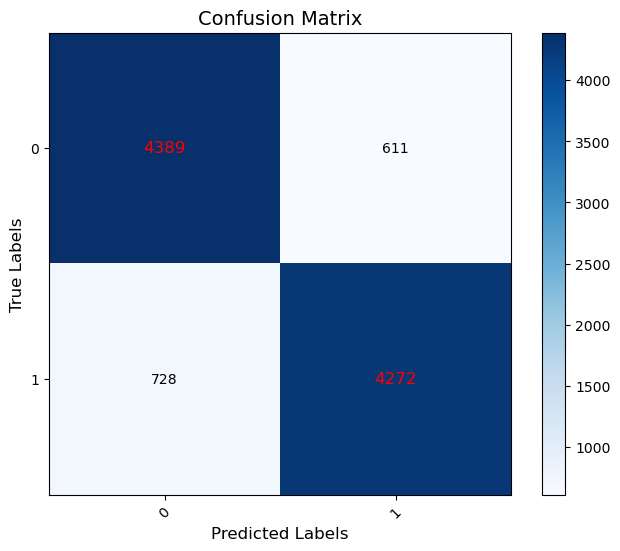

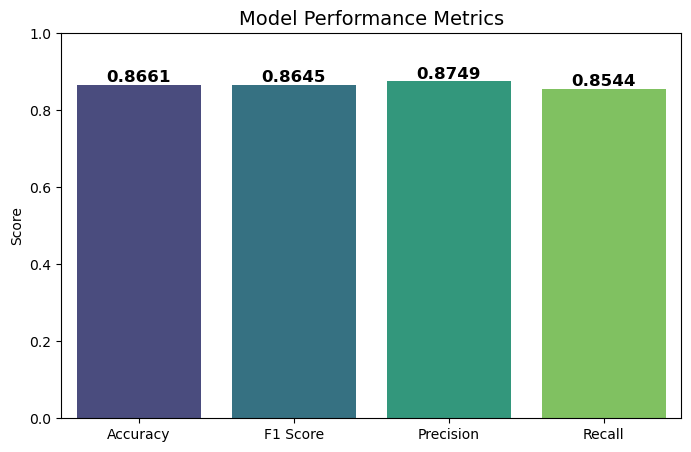

In [184]:


y_true_MoE_test,y_pred_MoE_test = compute_y_pred_true_for_classification(MoE_model, test_loader)
plot_confusion_matrix( y_true_MoE_test, y_pred_MoE_test)

plot_metrics_for_binary_classification( y_true_MoE_test, y_pred_MoE_test)

Let's see how accurate we can get with a simple logistic regression model.

In [186]:
# Define a simple logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Single neuron
        self.sigmoid = nn.Sigmoid()  # Activation function

    def forward(self, x):
        return self.sigmoid(self.linear(x))  # Apply sigmoid after linear transformation


Epoch 1/15, Loss: 0.5077, Validation loss: 0.3919
Epoch 2/15, Loss: 0.3143, Validation loss: 0.3287
Epoch 3/15, Loss: 0.2452, Validation loss: 0.3016
Epoch 4/15, Loss: 0.2060, Validation loss: 0.2869
Epoch 5/15, Loss: 0.1799, Validation loss: 0.2783
Epoch 6/15, Loss: 0.1611, Validation loss: 0.2730
Epoch 7/15, Loss: 0.1468, Validation loss: 0.2694
Epoch 8/15, Loss: 0.1355, Validation loss: 0.2673
Epoch 9/15, Loss: 0.1265, Validation loss: 0.2653
Epoch 10/15, Loss: 0.1190, Validation loss: 0.2644
Epoch 11/15, Loss: 0.1128, Validation loss: 0.2636
Epoch 12/15, Loss: 0.1076, Validation loss: 0.2634
Epoch 13/15, Loss: 0.1031, Validation loss: 0.2628
Epoch 14/15, Loss: 0.0992, Validation loss: 0.2627
Epoch 15/15, Loss: 0.0959, Validation loss: 0.2624


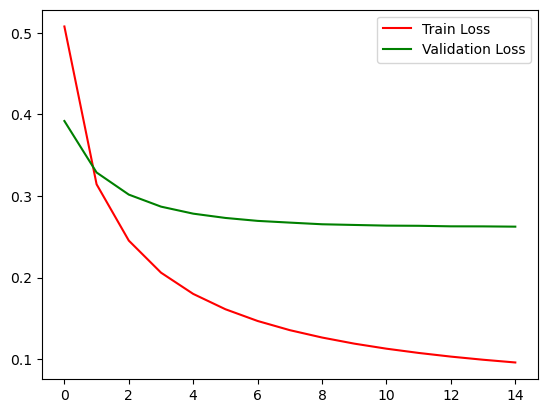

In [187]:

# Hyperparameters
num_epochs = 15
learning_rate = 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
logistic_model = LogisticRegressionModel(input_dim).to(device)

# Convert labels to float for BCE loss
y = y.type(torch.float).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss (because sigmoid is now included)
optimizer = optim.Adam(logistic_model.parameters(), lr=learning_rate)
# Initialize the ExponentialLR scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)  # Decay by 5% each epoch

# Track loss
track_loss = []
track_val_loss = []

# Training loop
for epoch in range(num_epochs):
    logistic_model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.type(torch.float).view(-1, 1).to(device)

        optimizer.zero_grad()
        outputs = logistic_model(batch_X)  # Get model predictions
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        
        epoch_loss += loss.item()

    track_loss.append(epoch_loss / len(train_loader))

    # Compute validation loss
    logistic_model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.type(torch.float).view(-1, 1).to(device)
        
            outputs = logistic_model(batch_X)
            loss = criterion(outputs, batch_y)
        
            val_loss += loss.item()
    
        val_loss /= len(val_loader)

    
    track_val_loss.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {track_loss[-1]:.4f}, Validation loss: {track_val_loss[-1]:.4f}")

    scheduler.step()
# Plot training & validation loss
plt.plot(track_loss, label='Train Loss', color='red')
plt.plot(track_val_loss, label='Validation Loss', color='green')
plt.legend()
plt.show()

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\3623986010.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")


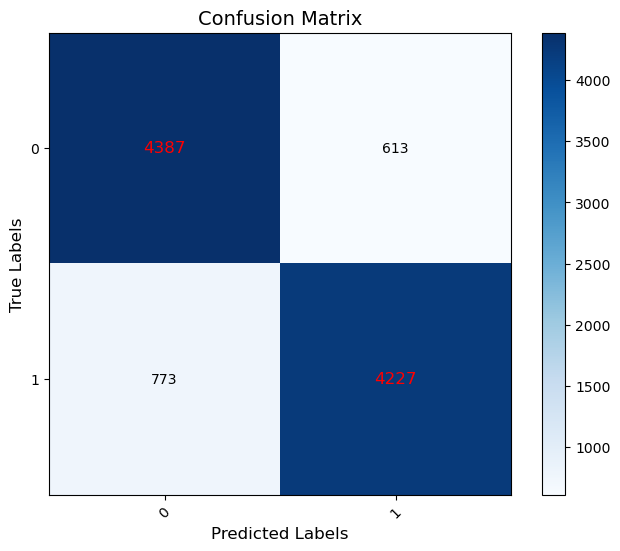

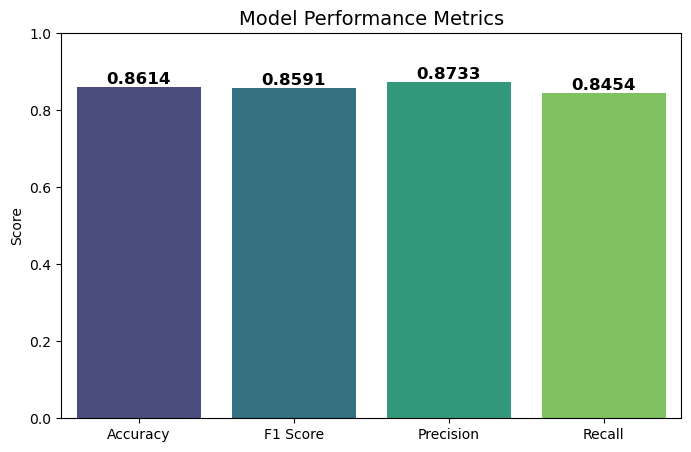

In [188]:
# This function that we defined for the classification model needs to be redefined since a regression does
#only have an output of dimension 1
def compute_y_pred_true_for_regression(model, test_loader):

    #Let's first generate the y_pred and y_true vectors
    with torch.no_grad():
        y_pred = []
        y_true = []
    
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            
            predictions = (output >= 0.5).long().view(-1)
        
            y_pred.append(predictions.cpu())  # Store predictions
            y_true.append(batch_y.cpu())  # Store true labels
    # Concatenate lists into single tensors
    y_pred = torch.cat(y_pred).numpy()
    y_true = torch.cat(y_true).numpy()

    return (y_true,y_pred)



y_true_logistic_test,y_pred_logistic_test = compute_y_pred_true_for_regression(logistic_model, test_loader)
plot_confusion_matrix(y_true_logistic_test,y_pred_logistic_test)

plot_metrics_for_binary_classification( y_true_logistic_test,y_pred_logistic_test)

It is thus better to use the logistic regression since it is a way simpler model that performs as well as MoE over this dataset.


## 3) Word2vec embedding
   
Let's now do the same classification using a different text embedding : word2vec. The word2vec embedding will be trained over the training dataset itself. We first need to restore the original dataset in order to reduce the ammount of preprocessing steps done over it, in order to be better adapted for word2vec.
We will then try 2 different models : CNN and LSTM.

In [191]:
dataset = load_dataset("imdb")

# Get the training and test datasets
train_data = dataset['train']
test_data = dataset['test']

positive_samples = train_data.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(nb_of_samples))
negative_samples = train_data.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(nb_of_samples))

# Merge and shuffle the two datasets 
train_val_sample = concatenate_datasets([positive_samples, negative_samples]).shuffle(seed=42)

# Create validation split (80% train, 20% validation)
train_size = int(0.8 * len(train_val_sample))  # 80% for training
val_size = len(train_val_sample) - train_size  # 20% for validation

train_sample = train_val_sample.select(range(train_size))
val_sample = train_val_sample.select(range(train_size, len(train_val_sample)))


#We make a test set of half the size of the training set
nb_of_test_samples=int(nb_of_samples/2)
positive_test_samples = test_data.filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(nb_of_test_samples))
negative_test_samples = test_data.filter(lambda x: x['label'] == 0).shuffle(seed=42).select(range(nb_of_test_samples))

test_sample = concatenate_datasets([positive_test_samples, negative_test_samples]).shuffle(seed=42)

print(f"There are {len(train_sample)} training samples, {len(val_sample)} validation samples and {len(test_sample)} test samples.")


There are 16000 training samples, 4000 validation samples and 10000 test samples.


In [192]:
# Define preprocessing function for Word2Vec
def preprocess_text_for_word2vec(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    
    # Return the tokens (no stemming or lemmatization for Word2Vec)
    return tokens

# Apply the preprocessing function to the reviews
train_sample = train_sample.map(lambda x: {'text': preprocess_text_for_word2vec(x['text'])})
test_sample = test_sample.map(lambda x: {'text': preprocess_text_for_word2vec(x['text'])})
val_sample = val_sample.map(lambda x: {'text': preprocess_text_for_word2vec(x['text'])})

# Check the preprocessed data
print(train_sample[0])


{'text': ['two', 'kinds', 'movies', 'like', 'westerns', 'movies', 'years', 'ago', 'ought', 'liked', 'man', 'called', 'sledge', 'br', 'br', 'picture', 'disagreeable', 'annoying', 'stupid', 'start', 'finish', 'since', 'nobody', 'story', 'good', 'bad', 'warm', 'nobody', 'motivate', 'necessary', 'suspense', 'keep', 'viewer', 'interested', 'camaraderie', 'among', 'guys', 'trying', 'steal', 'gold', 'camaraderie', 'among', 'trying', 'protect', 'sledge', 'pretty', 'girl', 'friend', 'reason', 'slobbers', 'guy', 'wants', 'room', 'br', 'br', 'film', 'also', 'suffers', 'intrusive', 'gawdawful', 'musical', 'score', 'extremely', 'bad', 'writing', 'direction', 'vic', 'br', 'br', 'last', 'older', 'movies', 'rented', 'netflix', 'video', 'vault', 'rock', 'bottom', 'true', 'dud', 'bunch'], 'label': 0}


Now let's train a word2vec model on our training dataset

In [194]:

# Sample corpus (list of preprocessed texts)
corpus=train_sample[:]['text']
labels = train_sample[:]['label']

# Sample validation corpus (list of preprocessed texts)
val_corpus = val_sample[:]['text']
val_labels = val_sample[:]['label']

# Sample test corpus (list of preprocessed texts)
test_corpus = test_sample[:]['text']
test_labels = test_sample[:]['label']


# Train Word2Vec model
embedding_dim = 100
word2vec_emb = Word2Vec(sentences=corpus, vector_size=embedding_dim, window=5, min_count=1, sg=1, epochs=10)

# Save and load the model
#model.save("word2vec.model")
#word2vec_emb = Word2Vec.load("word2vec.model")

# Get vector for a word
vector = word2vec_emb.wv["learning"]
print(vector)  # Prints a 100-dimensional vector



[-0.42069003 -0.08282776  0.2949004   0.21429549  0.25159556 -0.5194932
  0.04744521  0.5668792  -0.12248991 -0.26036394 -0.04275474 -0.1246355
 -0.12597859  0.19692239 -0.29393324 -0.28604132  0.17590998 -0.16955331
  0.15845448 -0.45055556  0.4761135   0.14919142  0.24751593  0.4147865
  0.23023196 -0.11680185 -0.45714596  0.07961924 -0.1909535   0.46925408
  0.24142246 -0.00452473  0.01308381 -0.26451614 -0.00307087  0.00669752
  0.26215196  0.04315049 -0.32644302 -0.347744   -0.13348877  0.18705395
  0.17264043  0.1821377   0.07019297 -0.72763944 -0.30036706 -0.593181
  0.05625536 -0.01515898 -0.26331243 -0.5354508  -0.18043411 -0.13381024
  0.07466066  0.19732367 -0.12940037 -0.16099556 -0.02052896 -0.31136414
 -0.1706797   0.3547346  -0.04445052  0.19924884 -0.67906535 -0.32392776
  0.28524998  0.49976793 -0.48814577  0.5612648   0.29011583 -0.32303944
  0.3435981  -0.06462692  0.05250693 -0.01810727  0.05405325  0.09785184
 -0.42499605 -0.23634203 -0.5630983   0.21075645 -0.6130

Let's confirm the nice properties of our model.

In [196]:
print("Distance between movie and film",((word2vec_emb.wv["movie"] - word2vec_emb.wv["film"])**2).mean())
print("Distance between movie and action",((word2vec_emb.wv["movie"] - word2vec_emb.wv["action"])**2).mean())
print("Distance between action and film",((word2vec_emb.wv["film"] - word2vec_emb.wv["action"])**2).mean())

Distance between movie and film 0.011543976
Distance between movie and action 0.09500964
Distance between action and film 0.10266016


Now let's embedd our text corpus 

In [198]:
def embed_review(review):
    """ Convert a review into a sequence of word2vec embeddings """
    return np.array([word2vec_emb.wv[word] for word in review if word in word2vec_emb.wv])

# Convert text corpus into numerical embeddings
train_embedded_reviews = [embed_review(text) for text in corpus]
test_embedded_reviews = [embed_review(text) for text in test_corpus]
val_embedded_reviews = [embed_review(text) for text in val_corpus]

We want to have a fixed size for the CNN's input. We will therefore fix a standard length, complete the shorter reviews by zeroes and truncate the longer ones. Another way would be to look for a pooling but we will leave this idea for future work.
To decide of a standard length, we are helped by the EDA.

In [200]:
standard_length = 200

from torch.nn.utils.rnn import pad_sequence

train_padded_reviews = pad_sequence(
    [torch.tensor(review[:standard_length]) if len(review) > standard_length else torch.cat([torch.tensor(review), torch.zeros(standard_length - len(review), embedding_dim)]) for review in train_embedded_reviews],
    batch_first=True
)
test_padded_reviews = pad_sequence(
    [torch.tensor(review[:standard_length]) if len(review) > standard_length else torch.cat([torch.tensor(review), torch.zeros(standard_length - len(review), embedding_dim)]) for review in test_embedded_reviews],
    batch_first=True
)
val_padded_reviews = pad_sequence(
    [torch.tensor(review[:standard_length]) if len(review) > standard_length else torch.cat([torch.tensor(review), torch.zeros(standard_length - len(review), embedding_dim)]) for review in val_embedded_reviews],
    batch_first=True
)




In [201]:
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X = train_padded_reviews.to(device)
y = torch.tensor(labels).to(device)
X_test=test_padded_reviews.to(device)
y_test=torch.tensor(test_labels).to(device)
X_val=val_padded_reviews.to(device)
y_val=torch.tensor(val_labels).to(device)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [202]:
# Define CNN Model
class CNNClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes,standard_length, dropout_rate=0):
        super(CNNClassifier, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Second Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        

        # Fully Connected Layer
        self.fc = nn.Linear(128 , num_classes)  # Adjusted for pooled output size

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)  # Convert shape to [batch, embedding_dim, text_length]

        x = F.relu(self.conv1(x))  #First conv1D
        x = self.pool1(x)  # First Pooling Layer

        x = F.relu(self.conv2(x)) 
        x = self.pool2(x)  # Second Pooling Layer

        x = torch.mean(x, dim=2)
        
        x = self.dropout(x)

        # Final Classification dense Layers
        x = self.fc(x)
        return x




Epoch 1/12, Loss: 0.4537, Validation Loss: 0.3512
Epoch 2/12, Loss: 0.3393, Validation Loss: 0.3316
Epoch 3/12, Loss: 0.3207, Validation Loss: 0.3469
Epoch 4/12, Loss: 0.3033, Validation Loss: 0.3117
Epoch 5/12, Loss: 0.2940, Validation Loss: 0.3048
Epoch 6/12, Loss: 0.2896, Validation Loss: 0.3013
Epoch 7/12, Loss: 0.2791, Validation Loss: 0.2958
Epoch 8/12, Loss: 0.2728, Validation Loss: 0.3032
Epoch 9/12, Loss: 0.2680, Validation Loss: 0.2934
Epoch 10/12, Loss: 0.2592, Validation Loss: 0.2925
Epoch 11/12, Loss: 0.2524, Validation Loss: 0.2942
Epoch 12/12, Loss: 0.2455, Validation Loss: 0.3054


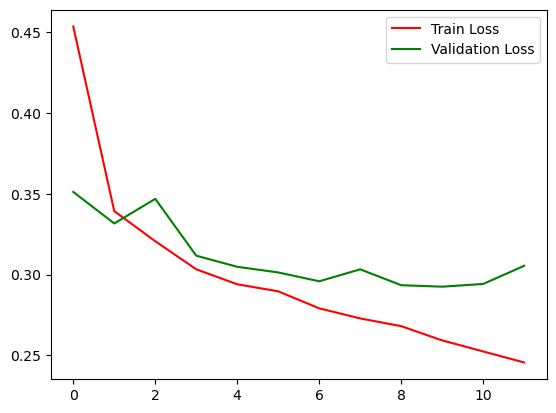

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\3623986010.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")


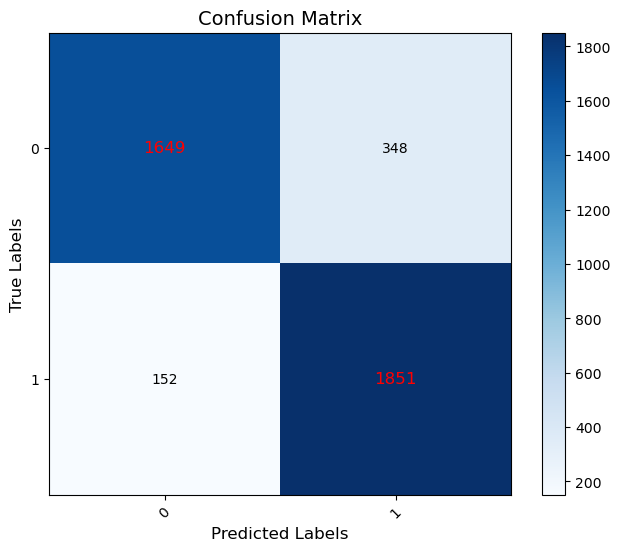

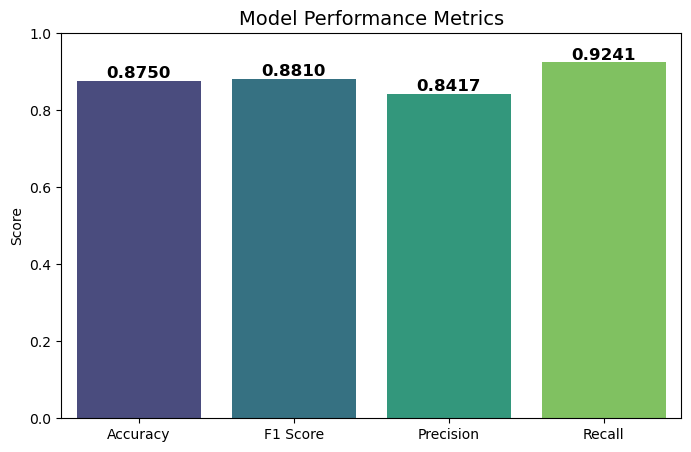

In [203]:
output_dim = 2  # Number of output classes (e.g., binary classification)

num_epochs = 12
learning_rate = 0.002




training_dropout=0.3
CNN_model = CNNClassifier(embedding_dim, 2, standard_length,training_dropout)
CNN_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model.parameters(), lr=learning_rate)
# Initialize the ExponentialLR scheduler
scheduler = ExponentialLR(optimizer, gamma=0.85)  # Decay by 5% each epoch


track_loss = []
track_val_loss = []
track_val_accuracy=[]

# Training loop with mini-batches
for epoch in range(num_epochs):
    CNN_model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = CNN_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Compute average loss
    track_loss.append(epoch_loss / len(train_loader))
    
    # Compute validation loss
    CNN_model.eval()

    
    track_val_loss.append(compute_average_loss(CNN_model, criterion, val_loader, device))

    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {track_loss[-1]:.4f}, Validation Loss: {track_val_loss[-1]:.4f}")

    scheduler.step()

# Plot the loss curves
plt.plot(track_loss, label='Train Loss', color='red')
plt.plot(track_val_loss, label='Validation Loss', color='green')
plt.legend()
plt.show()

y_true_CNN_val,y_pred_CNN_val = compute_y_pred_true_for_classification(CNN_model, val_loader)
plot_confusion_matrix(y_true_CNN_val, y_pred_CNN_val)
plot_metrics_for_binary_classification( y_true_CNN_val, y_pred_CNN_val)

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\3623986010.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")


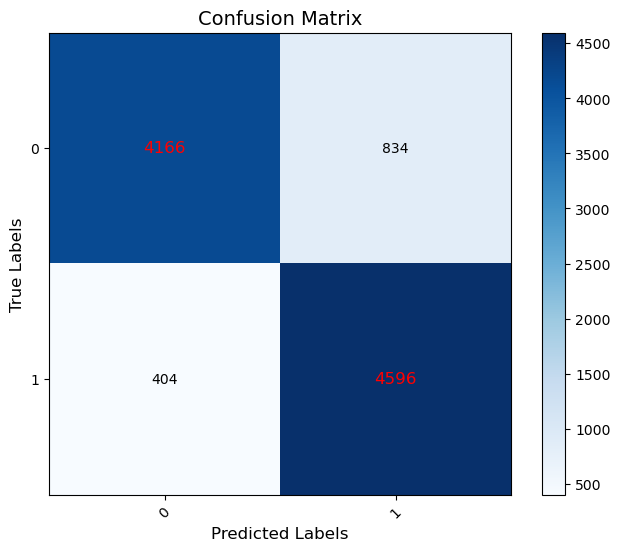

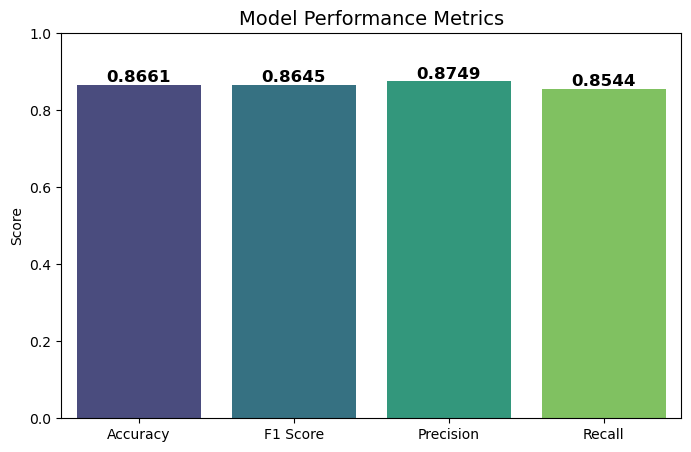

In [204]:

y_true_CNN_test,y_pred_CNN_test = compute_y_pred_true_for_classification(CNN_model, test_loader)
plot_confusion_matrix(y_true_CNN_test,y_pred_CNN_test)
plot_metrics_for_binary_classification( y_true_MoE_test, y_pred_MoE_test)

Now let's try this with a LSTM

In [206]:

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes, dropout_rate=0.5):
        super(LSTMClassifier, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=True
        )
        
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 because of bidirectional LSTM
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM forward pass
        last_hidden = lstm_out[:, -1, :]  # Extract last hidden state
        last_hidden = self.dropout(last_hidden)  # Apply dropout
        logits = self.fc(last_hidden)  # Fully connected layer
        return torch.sigmoid(logits)  # Binary classification output



Epoch 1/25, Loss: 0.6892, Validation Loss: 0.7041
Epoch 2/25, Loss: 0.6864, Validation Loss: 0.6930
Epoch 3/25, Loss: 0.6905, Validation Loss: 0.6902
Epoch 4/25, Loss: 0.6887, Validation Loss: 0.6874
Epoch 5/25, Loss: 0.5684, Validation Loss: 0.4714
Epoch 6/25, Loss: 0.4521, Validation Loss: 0.4538
Epoch 7/25, Loss: 0.4415, Validation Loss: 0.4435
Epoch 8/25, Loss: 0.4330, Validation Loss: 0.4378
Epoch 9/25, Loss: 0.4334, Validation Loss: 0.4414
Epoch 10/25, Loss: 0.4244, Validation Loss: 0.4397
Epoch 11/25, Loss: 0.4199, Validation Loss: 0.4383
Epoch 12/25, Loss: 0.4154, Validation Loss: 0.4384
Epoch 13/25, Loss: 0.4112, Validation Loss: 0.4460
Epoch 14/25, Loss: 0.4085, Validation Loss: 0.4402
Epoch 15/25, Loss: 0.4048, Validation Loss: 0.4407
Epoch 16/25, Loss: 0.4011, Validation Loss: 0.4401
Epoch 17/25, Loss: 0.3990, Validation Loss: 0.4405
Epoch 18/25, Loss: 0.3960, Validation Loss: 0.4413
Epoch 19/25, Loss: 0.3943, Validation Loss: 0.4411
Epoch 20/25, Loss: 0.3923, Validation Lo

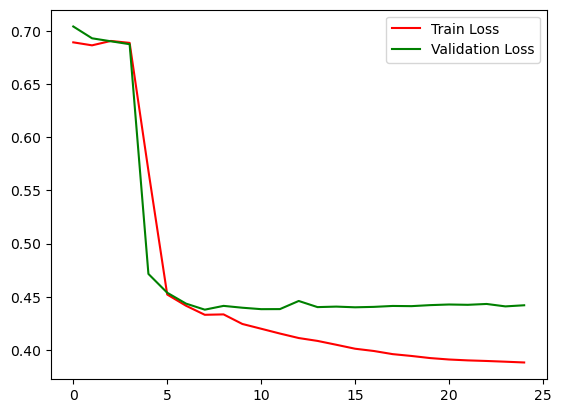

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\3623986010.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")


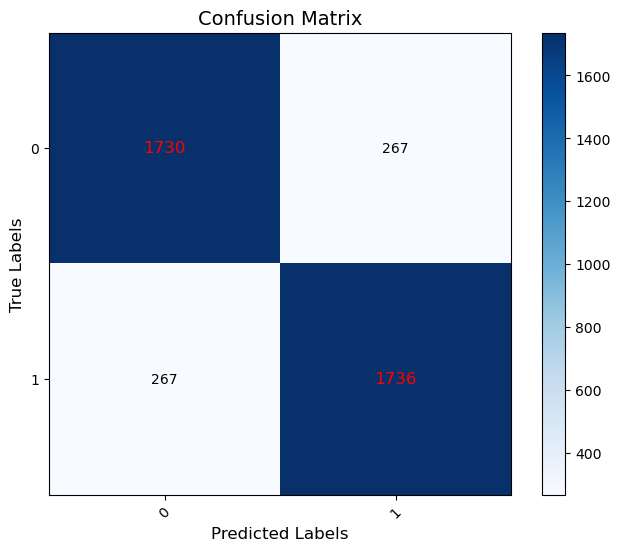

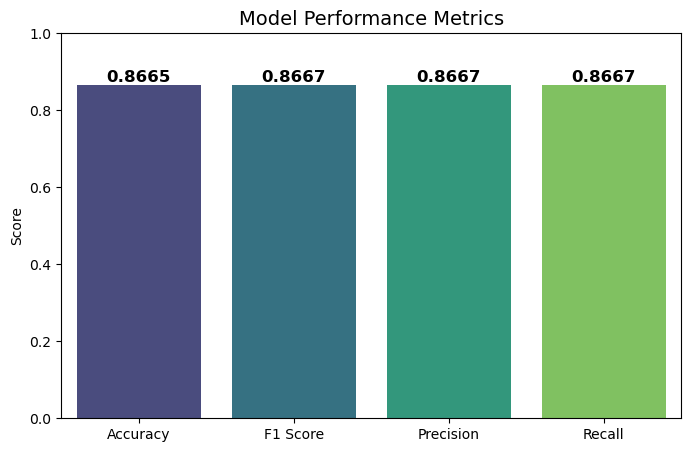

In [207]:
output_dim = 2  # Number of output classes (e.g., binary classification)
batch_size = 256
num_epochs = 25
learning_rate = 0.008



training_dropout=0.2
LSTM_model = LSTMClassifier(embedding_dim, hidden_dim=128, num_layers=2, num_classes=2,dropout_rate=training_dropout)
LSTM_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate)
# Initialize the ExponentialLR scheduler
scheduler = ExponentialLR(optimizer, gamma=0.85)  # Decay by 5% each epoch


track_loss = []
track_val_loss = []
track_val_accuracy=[]

# Training loop with mini-batches
for epoch in range(num_epochs):
    LSTM_model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = LSTM_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Compute average loss
    track_loss.append(epoch_loss / len(train_loader))
    
    # Compute validation loss
    LSTM_model.eval()

    
    track_val_loss.append(compute_average_loss(LSTM_model, criterion, val_loader, device))

    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {track_loss[-1]:.4f}, Validation Loss: {track_val_loss[-1]:.4f}")

    scheduler.step()

# Plot the loss curves
plt.plot(track_loss, label='Train Loss', color='red')
plt.plot(track_val_loss, label='Validation Loss', color='green')
plt.legend()
plt.show()

y_true_LSTM_val,y_pred_LSTM_val = compute_y_pred_true_for_classification(LSTM_model, val_loader)
plot_confusion_matrix(y_true_LSTM_val, y_pred_LSTM_val)
plot_metrics_for_binary_classification(y_true_LSTM_val,y_pred_LSTM_val)

C:\Users\sidis\AppData\Local\Temp\ipykernel_20792\3623986010.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x="Metric", y="Value", hue=None, palette="viridis")


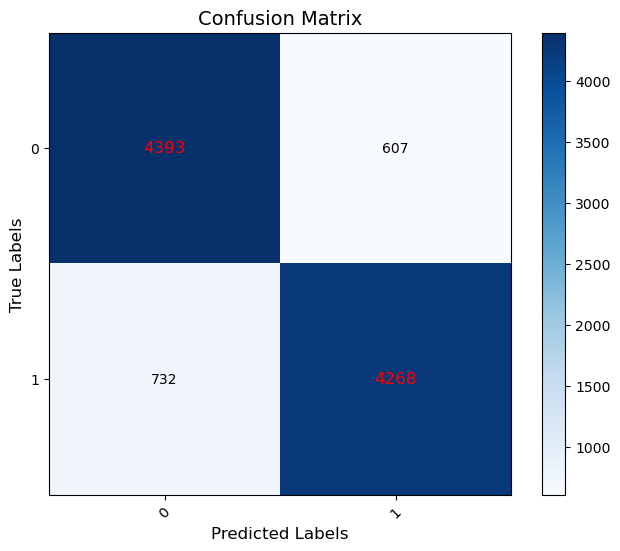

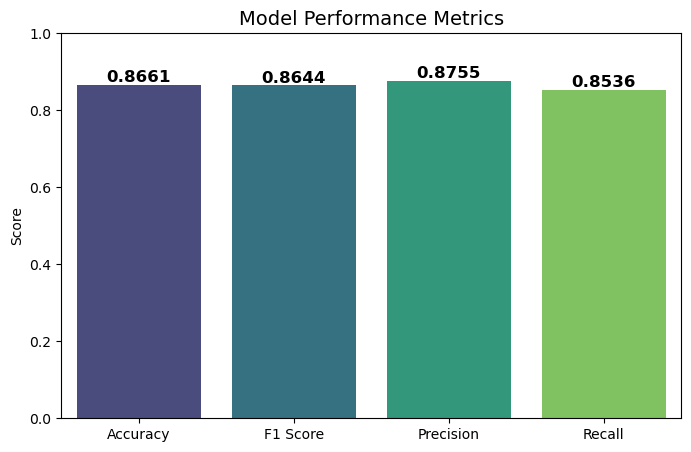

In [208]:
y_true_LSTM_test,y_pred_LSTM_test = compute_y_pred_true_for_classification(LSTM_model, test_loader)
plot_confusion_matrix(y_true_LSTM_test,y_pred_LSTM_test)
plot_metrics_for_binary_classification(y_true_LSTM_test,y_pred_LSTM_test)

## 4) Conclusion
Let's plot the metrics for the different models

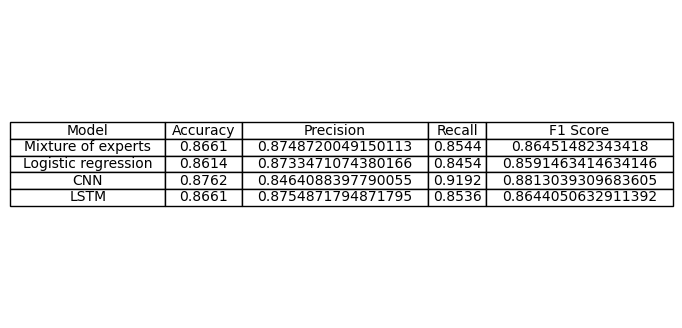

In [210]:

results = [
    ("Mixture of experts", y_true_MoE_test,y_pred_MoE_test),
    ("Logistic regression", y_true_logistic_test,y_pred_logistic_test),
    ("CNN", y_true_CNN_test,y_pred_CNN_test),
    ("LSTM", y_true_LSTM_test,y_pred_LSTM_test),
]

# Initialize lists to hold the metrics
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Loop over each tuple and calculate the metrics
for name, y_true, y_pred in results:
    model_names.append(name)
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))

# Create a DataFrame to organize the results
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(8, 4))  # You can adjust the size of the figure
ax.axis('tight')
ax.axis('off')

# Display the table
table = ax.table(cellText=metrics_df.values,
                colLabels=metrics_df.columns,
                cellLoc='center',
                loc='center')

# Adjust the font size and layout
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(metrics_df.columns))))

# Show the plot
plt.show()


As we ca see, the word2vec approaches generally gives better results on all metrics, which is expected since it keeps information about the structure of the text, and thus captures more information than the TF-IDF approaches. The CNN is slightly better than the LSTM because it is good at capturing local patterns (example : "very bad") when the LSTMs are better for long term dependencies, which is less required for text inputs of size 200. 